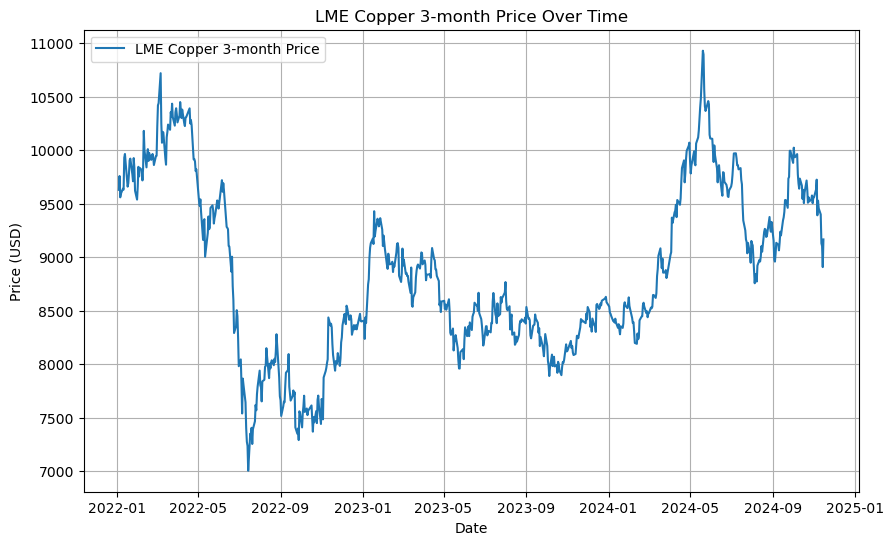

In [1]:
import numpy as np
import math
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

path = r"C:\Users\Jerry\Desktop\CV\trafi\prices.csv"
prices = pd.read_csv(path, index_col = 'date')
prices.index = pd.to_datetime(prices.index, format='%d. %B %Y', errors='coerce')
prices['LME Copper 3-month'] = pd.to_numeric(prices['LME Copper 3-month'], errors='coerce')
prices['LME Copper Cash-Settlement'] = pd.to_numeric(prices['LME Copper Cash-Settlement'], errors='coerce')
prices['LME Copper stock'] = pd.to_numeric(prices['LME Copper stock'], errors='coerce')
prices = prices.sort_index()
prices.dropna(inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(prices.index, prices["LME Copper 3-month"], label="LME Copper 3-month Price")
plt.title("LME Copper 3-month Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [2]:
start_date = '2024-09-30'
historical_prices = prices.loc[:start_date, 'LME Copper 3-month']
initial_mean = historical_prices.mean()
S0 = historical_prices.iloc[-1]  # starting price (last known price before simulation)
T = 0.25  # time horizon (1 year)
num_steps = 63 * 390
dt = T / num_steps # time in years between each step
kappa = 0.5  # constant speed of mean reversion
sigma = historical_prices.std()  # constant volatility

def simulate_dynamic_mean(S0, num_steps, kappa, sigma, initial_mean, historical_prices):
    simulated_prices = np.zeros(num_steps)
    simulated_prices[0] = S0
    dynamic_mean = initial_mean
    
    for t in range(1, num_steps):
        # combine historical prices and simulated prices up to the current step
        updated_prices = np.concatenate([historical_prices.values, simulated_prices[:t]])
        dynamic_mean = updated_prices.mean()
        
        # mean-reverting dynamics
        drift = kappa * (dynamic_mean - simulated_prices[t-1]) * dt
        shock = sigma * np.sqrt(dt) * np.random.normal()
        simulated_prices[t] = simulated_prices[t-1] + drift + shock
    
    return simulated_prices

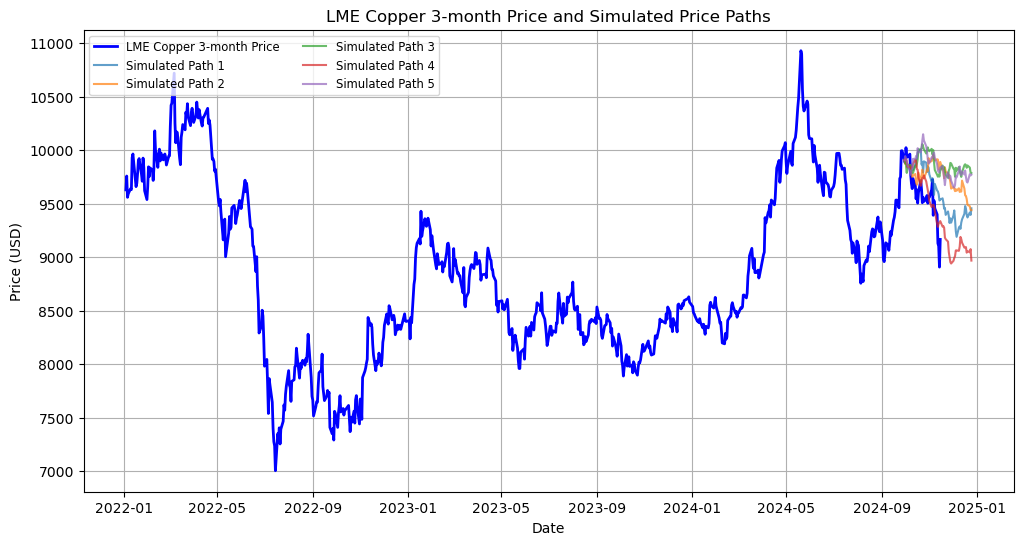

In [6]:
simulated_dates_daily = pd.date_range(start=start_date, periods=63, freq='B')  # business days

num_simulations = 5  # number of simulated paths
simulated_paths = []

for i in range(num_simulations):
    simu = simulate_dynamic_mean(S0, num_steps, kappa, sigma, initial_mean, historical_prices)
    simulated_paths.append(simu)


plt.figure(figsize=(12, 6))
plt.plot(prices.index, prices["LME Copper 3-month"], label="LME Copper 3-month Price", color="blue", linewidth=2)
for i, path in enumerate(simulated_paths):
    plt.plot(simulated_dates_daily, path[::390], label=f"Simulated Path {i+1}", alpha=0.7)
plt.title("LME Copper 3-month Price and Simulated Price Paths")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(loc="upper left", fontsize="small", ncol=2)
plt.grid(True)
plt.show()


In [8]:
r = 0.0437
payoffs_call = np.zeros(10000)
payoffs_put = np.zeros(10000)

# run simulations and calculate payoffs
for i in range(10000):
    simu = simulate_dynamic_mean(S0, num_steps, kappa, sigma, initial_mean, historical_prices)
    S_T = simu[-1]  # final simulated price at maturity
    
    # compute payoffs
    payoffs_call[i] = max(S_T - S0, 0)
    payoffs_put[i] = max(S0 - S_T, 0)

# discounted payoffs
discounted_call = np.exp(-r * T) * payoffs_call
discounted_put = np.exp(-r * T) * payoffs_put

# option prices
call_price = np.mean(discounted_call)
put_price = np.mean(discounted_put)
print(call_price)
print(put_price)

144.6569468719194
157.83360196867497
